# <div align="center">Présentation générale du jeu de données</div>



## Import des paquets nécessaires et vue d'ensemble du dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def readData():
    data = pd.read_csv("p2-arbres-fr.csv", sep =";")
    df = data.copy()
    return df
    
df = readData()

Nombres d'individus: 200137
Nombres de variables : 18 

Types de variables :
id                       int64
type_emplacement        object
domanialite             object
arrondissement          object
complement_addresse     object
numero                 float64
lieu                    object
id_emplacement          object
libelle_francais        object
genre                   object
espece                  object
variete                 object
circonference_cm         int64
hauteur_m                int64
stade_developpement     object
remarquable            float64
geo_point_2d_a         float64
geo_point_2d_b         float64
dtype: object
Nombres de variables de type int : 3
Nombres de variables de type float : 4
Nombres de variables de type object : 11 

Pourcentages de valeurs manquantes :
id                     0.000000
hauteur_m              0.000000
circonference_cm       0.000000
geo_point_2d_a         0.000000
id_emplacement         0.000000
lieu                   0.000000
geo

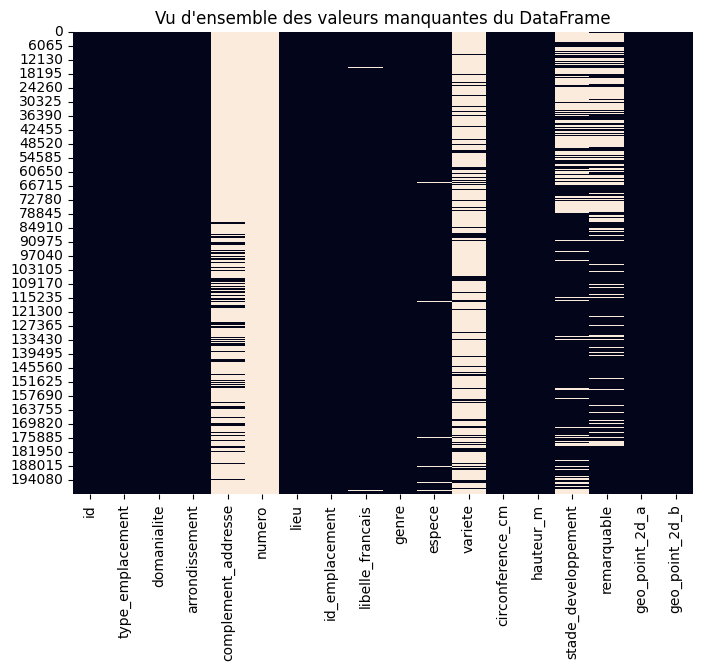

In [2]:
def analyseData():
    print("Nombres d'individus:", df.shape[0])
    print("Nombres de variables :", df.shape[1], "\n")
    print("Types de variables :")
    print(df.dtypes)
    print("Nombres de variables de type int : 3")
    print("Nombres de variables de type float : 4")
    print("Nombres de variables de type object : 11", "\n")
    print("Pourcentages de valeurs manquantes :")
    print(df.isna().mean().sort_values())

def printDataHeatmap():
    plt.figure(figsize= (8,6))
    print(sns.heatmap(df.isna(), cbar= False))
    plt.title("Vu d'ensemble des valeurs manquantes du DataFrame")
    plt.show()
    
analyseData()
printDataHeatmap()

**Remarque:**    
On remarque que 3 variables possèdent plus de 80% de valeurs manquantes. Il s'agit de "numero", "complement adresse" et "variete".  
On observe également que les variables "stade_developpement" et remarquable possèdent un peu plus de 30% de valeurs manquantes.

In [3]:
print("Il y a " ,df.duplicated('id').sum(), "duplicata dans le DataFrame" )

Il y a  0 duplicata dans le DataFrame


## Suppression des variables inutilisables

On remarque que la variable "type_emplacement" ne possède qu'une seule modalité, elle sera donc inutile pour l'analyse de ce dataframe.

In [4]:
df['type_emplacement'].unique()

array(['Arbre'], dtype=object)

La variable remarquable possède plus de 30% de valeurs manquantes, ses modalités sont 0 ou 1. Après m'être renseigné sur opendata.paris.fr., j'ai pris le parti de supprimer cette variable de notre dataset.

In [5]:
df['remarquable'].unique()

array([ 0., nan,  1.])

Dans la cellule ci dessous nous allons supprimer les variables qui ont un pourcentage de valeurs manquantes supérieures à 80%.

In [6]:
def removeUselessData(data):
    data = data[data.columns[(data.isna().sum()/data.shape[0]) < 0.8]] 
    data = data.drop('type_emplacement', axis = 1)
    data = data.drop('remarquable', axis = 1)
    return data
df = removeUselessData(df)
df.shape

(200137, 13)

In [7]:
def indexNan():
    index_with_nan = df.index[df.isna().any(axis=1)]    
    display(index_with_nan)

def createSample():
    sample = df[df.stade_developpement.isna()]
    return sample

indexNan()
sample = createSample()

Int64Index([     0,      4,      5,      6,      7,     11,     12,     13,
                14,     15,
            ...
            200127, 200128, 200129, 200130, 200131, 200132, 200133, 200134,
            200135, 200136],
           dtype='int64', length=69109)

**Remarque :**  
A ce stade, sur les 69109 valeurs manquantes il y en a 67205 soit plus de 97% qui sont dans la variable "stade_developpement".  
J'ai donc décidé de créer un sous échantillon de ces 67205 individus.

### Conversion de la variable hauteur en mètres en centimètres
La variable hauteur s'exprime en mètres et la variable circonférence s'exprime en centimètres. Nous allons uniformiser l'ordre de grandeur de ces deux variables.

In [8]:
def convertMeasure(data):
    data['hauteur_cm'] = data['hauteur_m'] * 100
    data.drop('hauteur_m', 1, inplace = True)
    return data
df = convertMeasure(df)

C:\Users\aurel\AppData\Local\Temp\ipykernel_8228\642045465.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('hauteur_m', 1, inplace = True)


## Détection des outliers et des valeurs aberrantes des variables quantitatives

In [9]:
display(df.describe().round(2))

,id,circonference_cm,geo_point_2d_a,geo_point_2d_b,hauteur_cm
count,200137.00,200137.00,200137.00,200137.00,200137.00
mean,387202.68,83.38,48.85,2.35,1311.05
std,545603.24,673.19,0.03,0.05,197121.74
min,99874.00,0.00,48.74,2.21,0.00
25%,155927.00,30.00,48.84,2.31,500.00
50%,221078.00,70.00,48.85,2.35,800.00
75%,274102.00,115.00,48.88,2.39,1200.00
max,2024745.00,250255.00,48.91,2.47,88181800.00


**Remarque**:
Les variables circonference et hauteur possèdent des valeurs abberantes :  
Le max de circonference reprèsente un arbre d'une circonférence de 2 502 mètres.   
Le max de hauteur reprèsente un arbre d'une hauteur de 881 000 mètres.  
Le min de hauteur et circonférence est 0cm, nous allons faire en sorte de remplacer toutes ces valeurs à 0.

### Imputation des valeurs nulles des variables hauteur et circonférence

In [10]:
def count_null():
    missing_values = (df['hauteur_cm'] == 0) | (df['circonference_cm']== 0)
    print("Il existe" , missing_values.sum(), "individus qui ont pour hauteur OU circonference une valeur aberrante de 0.")
    missing_values_2 = (df['hauteur_cm'] == 0) & (df['circonference_cm']== 0)
    print("Il existe" , missing_values_2.sum(), " individus qui ont pour hauteur ET circonference une valeur aberrante de 0.")

count_null()

Il existe 39585 individus qui ont pour hauteur OU circonference une valeur aberrante de 0.
Il existe 25501  individus qui ont pour hauteur ET circonference une valeur aberrante de 0.


In [11]:
def create_agg():
    # On récupère les index des individus qui ont pour hauteur ou circonference 0
    index_aberrant = df.loc[(df['hauteur_cm'] ==0)  | (df['circonference_cm'] == 0), :].index 
    #On crée une dataframe sans les valeurs 0
    df_without_0 = df.drop(labels = index_aberrant, axis = 0)

    #on crée une agrégation par espèces avec la moyenne des hauteurs et la moyenne des circonférences sans les 0
    df_moyenne_par_espece = df_without_0.groupby('genre').agg({'hauteur_cm' : 'mean', 'circonference_cm': 'mean'})
    df_moyenne_par_espece.reset_index(inplace = True)
    
    #Permet de vérifier dans le df final que les valeurs remplacés correspondent bien à la moyenne de l'espèce
    display(df_moyenne_par_espece.loc[df_moyenne_par_espece['genre'] == "Tetradium"])
    display(df_moyenne_par_espece.loc[df_moyenne_par_espece['genre'] == "Populus"])
    display(df_moyenne_par_espece.loc[df_moyenne_par_espece['genre'] == "Castanea"])

def replace_null(data):
    #On remplace tous les 0 par des Nan pour les variables hauteur et circonference.
    data['hauteur_cm'].replace(0, np.nan, inplace=True)
    data['circonference_cm'].replace(0, np.nan, inplace = True)

    #On aggrège les données par le genre et on remplace les valeurs Nan par la moyenne du genre concernée.
    data['hauteur_cm']=df.groupby('genre', group_keys=False)['hauteur_cm'].apply(lambda x:x.fillna(x.mean()))
    data['circonference_cm'] = df.groupby('genre', group_keys=False)['circonference_cm'].apply(lambda x:x.fillna(x.mean()))
    return data

create_agg()
df = replace_null(df)
display(df)

,genre,hauteur_cm,circonference_cm
132,Tetradium,636.0,56.48


,genre,hauteur_cm,circonference_cm
107,Populus,1513.889851,130.578455


,genre,hauteur_cm,circonference_cm
24,Castanea,463.905325,32.053254


,id,domanialite,arrondissement,lieu,id_emplacement,libelle_francais,genre,espece,circonference_cm,stade_developpement,geo_point_2d_a,geo_point_2d_b,hauteur_cm
0,99874,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,20.000000,NaN,48.857620,2.320962,500.000000
1,99875,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,65.000000,A,48.857656,2.321031,800.000000
2,99876,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,90.000000,A,48.857705,2.321061,1000.000000
3,99877,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,60.000000,A,48.857722,2.321006,800.000000
4,99878,Jardin,PARIS 17E ARRDT,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,38.000000,NaN,48.890435,2.315289,636.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
200132,2024741,Jardin,BOIS DE VINCENNES,ARBORETUM DE L ECOLE DU BREUIL - ROUTE DE LA F...,720170151,NaN,Castanea,fargesii,32.296512,NaN,48.821957,2.456264,463.905325
200133,2024742,Jardin,BOIS DE VINCENNES,ARBORETUM DE L ECOLE DU BREUIL - ROUTE DE LA F...,720170152,Arbre aux mouchoirs,Davidia,involucrata,43.769231,NaN,48.823254,2.457935,633.333333
200134,2024743,Jardin,BOIS DE VINCENNES,ARBORETUM DE L ECOLE DU BREUIL - ROUTE DE LA F...,720170153,Peuplier,Populus,simonii,130.022307,NaN,48.822907,2.457970,1513.707165
200135,2024744,Jardin,BOIS DE VINCENNES,ARBORETUM DE L ECOLE DU BREUIL - ROUTE DE LA F...,720170154,Chêne,Quercus,n. sp.,73.556837,NaN,48.822522,2.455956,1002.357635


**Remarque**:  

Les valeurs qui ont remplacé les Nan dans le dataframe correspondent bien à la moyenne du genre de l'arbre.  
A ce stade nous avons remplacé toutes les valeurs nulles ainsi que certaines valeurs aberrantes des variables hauteur et  circonference.

## Vérification et nettoyage des variables qualitatives

In [12]:
def displayCategorical():
    for col in df.select_dtypes('object'):
        print(f'{col :-<50} {df[col].unique()}')
displayCategorical()

domanialite--------------------------------------- ['Jardin' 'Alignement' 'DJS' 'DFPE' 'CIMETIERE' 'DASCO' 'DAC'
 'PERIPHERIQUE' 'DASES' nan]
arrondissement------------------------------------ ['PARIS 7E ARRDT' 'PARIS 17E ARRDT' 'PARIS 16E ARRDT' 'PARIS 4E ARRDT'
 'PARIS 13E ARRDT' 'PARIS 12E ARRDT' 'PARIS 19E ARRDT' 'PARIS 14E ARRDT'
 'PARIS 15E ARRDT' 'PARIS 3E ARRDT' 'PARIS 20E ARRDT' 'PARIS 18E ARRDT'
 'PARIS 6E ARRDT' 'PARIS 11E ARRDT' 'PARIS 1ER ARRDT' 'PARIS 2E ARRDT'
 'PARIS 5E ARRDT' 'VAL-DE-MARNE' 'SEINE-SAINT-DENIS' 'HAUTS-DE-SEINE'
 'PARIS 9E ARRDT' 'PARIS 10E ARRDT' 'PARIS 8E ARRDT' 'BOIS DE BOULOGNE'
 'BOIS DE VINCENNES']
lieu---------------------------------------------- ['MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E'
 'PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING'
 'SQUARE ALEXANDRE ET RENE PARODI / 1 PLACE DE LA PORTE MAILLOT' ...
 'TERRAIN D EDUCATION PHYSIQUE / 49 RUE OLIVIER METRA' 'RUE EDOUARD QUENU'
 'RUE DU GENERAL NIESSEL']
id_emplacement-----------------------------

### Nettoyage de l'échantillon principal et suppression de la variable stade_developpement

In [13]:
def cleanCategoricalwithoutStadeDev(data):
    count_domanialite = data.groupby('domanialite')['id'].count()
    valide_object = count_domanialite.index
    data = data[data['domanialite'].isin(valide_object)]

    count_arrondissement = data.groupby('arrondissement')['id'].count()
    valide_object = count_arrondissement.index
    data = data[data['arrondissement'].isin(valide_object)]

    count_lieu = data.groupby('lieu')['id'].count()
    valide_object = count_lieu.index
    data = data[data['lieu'].isin(valide_object)]

    count_id_emp = data.groupby('id_emplacement')['id'].count()
    valide_object = count_id_emp.index
    data = data[data['id_emplacement'].isin(valide_object)]

    count_libelle = data.groupby('libelle_francais')['id'].count()
    valide_object = count_libelle.index
    data = data[data['libelle_francais'].isin(valide_object)]

    count_genre = data.groupby('genre')['id'].count()
    valide_object = count_genre.index
    data = data[data['genre'].isin(valide_object)]

    count_espece = data.groupby('espece')['id'].count()
    valide_object = count_espece.index
    data = data[data['espece'].isin(valide_object)]
    
    data.drop('stade_developpement', axis = 1, inplace = True)
    return data

df_1 = cleanCategoricalwithoutStadeDev(df)

**Remarque:**  
Ce code reproduit le nettoyage des variables qualitatives comme dans la boucle de la cellule ci dessous, à l'exception qu'on ne touche pas à la variable "stade_developpement" afin de ne pas perdre d'individus. A la place on supprime la variable "stade_developpement" du DataFrame.

### Création d'un second échantillon pour l'analyse de la variable stade_developpement

In [14]:
def cleanAllCategorical(data):
    print("Le nombre d'individus dans le dataframe à ce stade est de" ,df.shape[0])
    for obj in data.select_dtypes('object'):
        count_object = data.groupby(obj)['id'].count()
        valide_object = count_object.index
        data = data[data[obj].isin(valide_object)]
        print("Il reste", data.shape[0], "individus restants après le nettoyage de la variable :", obj)
    return data
        
df_2 = cleanAllCategorical(df)

Le nombre d'individus dans le dataframe à ce stade est de 200137
Il reste 200136 individus restants après le nettoyage de la variable : domanialite
Il reste 200136 individus restants après le nettoyage de la variable : arrondissement
Il reste 200136 individus restants après le nettoyage de la variable : lieu
Il reste 200136 individus restants après le nettoyage de la variable : id_emplacement
Il reste 198639 individus restants après le nettoyage de la variable : libelle_francais
Il reste 198639 individus restants après le nettoyage de la variable : genre
Il reste 197252 individus restants après le nettoyage de la variable : espece
Il reste 131028 individus restants après le nettoyage de la variable : stade_developpement


**Remarque:**  
Après l'analyse et le nettoyage des valeurs qualitatives, nous avons remarqué que la variable "stade_developpement" était la variable la moins bien remplie.
Nous avons donc crée 2 échantillons, un de 131028 individus avec la variable "stade_developpement" remplie.  
Et un autre échantillon de 197252 individus dont la variable "stade_developpement" a été supprimée.

# <div align="center">Démarche méthodologique d’analyse de données</div>

On récupère l'échantillon de 197252 individus comme échantillon principal :

In [15]:
df = df_1.copy()

## Analyse de la variable genre

On récupère les genres d'arbres qui representent plus de 2% des individus

In [16]:
def commonType():
    counts = df['genre'].value_counts(normalize = True)
    common_type = df[df['genre'].map(counts)>0.02] 
    return common_type
common_type = commonType()

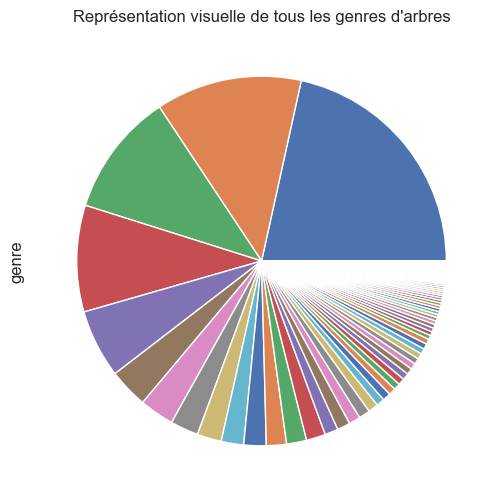

Il existe 175 genres d'arbres différents
Pour des raisons de lisibilité j'ai retiré les noms de genre d'arbres ainsi que les pourcentages correspondants.


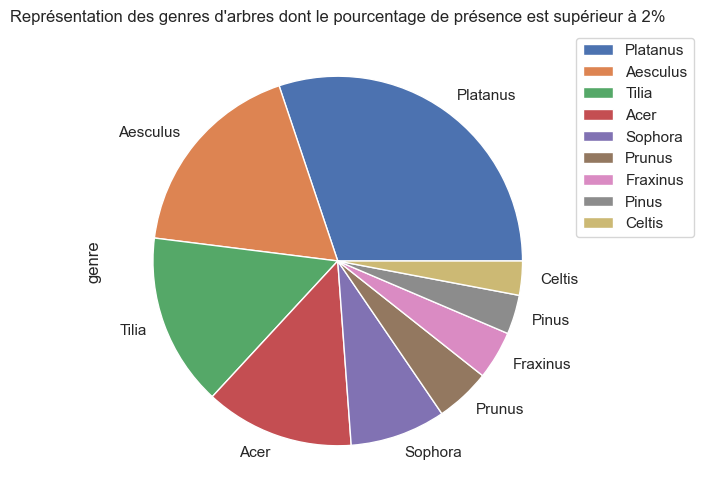

Notre échantillon common_type regroupe 71,5% des arbres de la ville de Paris avec 9 genres d'arbres.


In [17]:
sns.set_theme(context = "notebook", style = "whitegrid", palette = "deep")

def pieTypeTrees():
    plt.figure(figsize = (8,6))
    df['genre'].value_counts().plot.pie(labels = None)
    plt.title("Représentation visuelle de tous les genres d'arbres")
    plt.show()
    print("Il existe 175 genres d'arbres différents")
    print("Pour des raisons de lisibilité j'ai retiré les noms de genre d'arbres ainsi que les pourcentages correspondants.")
    
    plt.figure(figsize = (8,6))
    common_type['genre'].value_counts().plot.pie()
    plt.title("Représentation des genres d'arbres dont le pourcentage de présence est supérieur à 2%")
    plt.legend(loc="upper left",
          bbox_to_anchor=(1, 0, 0.5, 1))
    plt.show()
    print("Notre échantillon common_type regroupe 71,5% des arbres de la ville de Paris avec 9 genres d'arbres.")
    
pieTypeTrees()

## Analyse des variables quantitatives

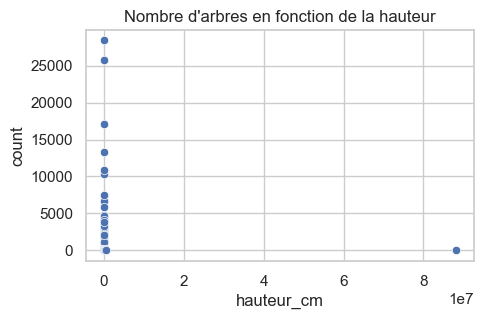

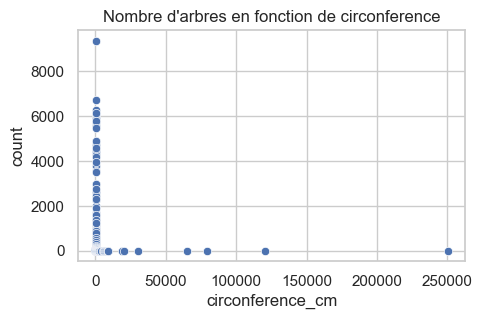

,id,circonference_cm,geo_point_2d_a,geo_point_2d_b,hauteur_cm
count,197252.00,197222.00,197252.00,197252.00,197217.00
mean,383568.76,94.87,48.85,2.35,1609.16
std,540868.81,677.40,0.03,0.05,198575.77
min,99874.00,1.00,48.74,2.21,100.00
25%,155511.75,50.00,48.84,2.31,600.00
50%,220694.50,80.00,48.85,2.35,1000.00
75%,273753.25,120.00,48.88,2.39,1353.17
max,2024745.00,250255.00,48.91,2.47,88181800.00


In [18]:
def scatterplot_height(data):
    plt.figure(figsize=(5,3))
    agg_hauteur = data.groupby(['hauteur_cm'])['id'].count().reset_index()
    agg_hauteur= agg_hauteur.rename(columns = {"id" : "count"})
    sns.scatterplot(data= agg_hauteur, x= "hauteur_cm", y = "count")
    plt.title("Nombre d'arbres en fonction de la hauteur")
    plt.show()
    
def scatterplot_girth(data):
    plt.figure(figsize=(5,3))
    agg_circ = data.groupby(['circonference_cm'])['id'].count().reset_index()
    agg_circ = agg_circ.rename(columns = {"id" : "count"})
    sns.scatterplot(data= agg_circ, x= "circonference_cm", y = "count")
    plt.title("Nombre d'arbres en fonction de circonference")
    plt.show()
    
scatterplot_height(df)
scatterplot_girth(df)
display(df.describe().round(2))

### Le critère de Tukey

**Le critère de Tukey**, propose de retirer les valeurs comprises hors de l'intervalle :
[Q1 - 1.5 x IQR ; Q3 +1.5 x IQR].  
Je vais utiliser cette règle uniquement pour les valeurs supérieures à Q3, en effet pour les valeurs inférieures à Q1, il est fort probable que ces arbres soient de jeunes arbres sans pour autant contenir de valeurs aberrantes.  

In [19]:
def detectOutliers(data):
    Q1_h = data['hauteur_cm'].quantile(.25)
    Q3_h = data['hauteur_cm'].quantile(.75)
    IQR_hauteur = Q3_h - Q1_h

    Q1_c = data['circonference_cm'].quantile(.25)
    Q3_c = data['circonference_cm'].quantile(.75)
    IQR_circonference = Q3_c-Q1_c

    limite_hauteur = (1.5* IQR_hauteur) + Q3_h
    limite_circonference = (1.5* IQR_circonference) + Q3_c

    print("La limite maximum pour la hauteur est de " , round(limite_hauteur,2), "cm")
    print("La limite maximum pour la circonférence est de" , round(limite_circonference,2), "cm \n")
    
    print("Nombres d'individus avant le tri: " ,data.shape[0])
    data = data.loc[data['hauteur_cm'] < limite_hauteur , :] 
    data = data.loc[data['circonference_cm'] < limite_circonference, :]
    print("Nombres d'individus après le tri: ", data.shape[0])
    return data
    
df = detectOutliers(df)

La limite maximum pour la hauteur est de  2482.93 cm
La limite maximum pour la circonférence est de 225.0 cm 

Nombres d'individus avant le tri:  197252
Nombres d'individus après le tri:  186045


Afin de vérifier l'hypothèse que les arbres les plus petits sont de jeunes arbres, j'affiche le stade de développement d'arbres inférieurs au centile .05 pour les variables "hauteur_cm" et "circonference_cm".

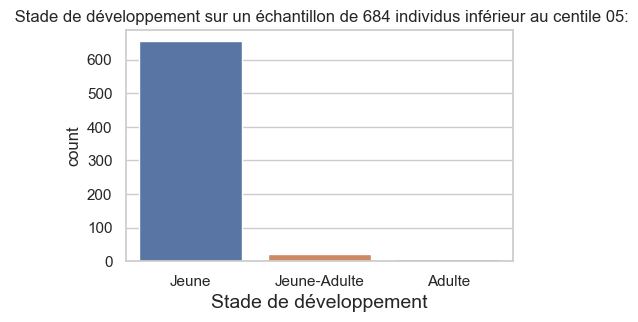

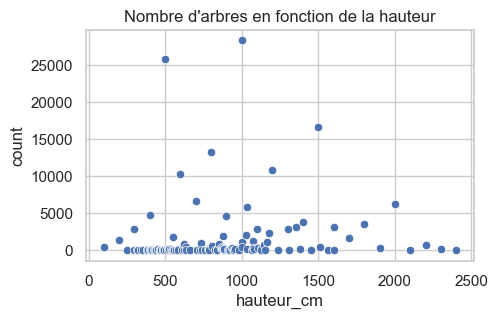

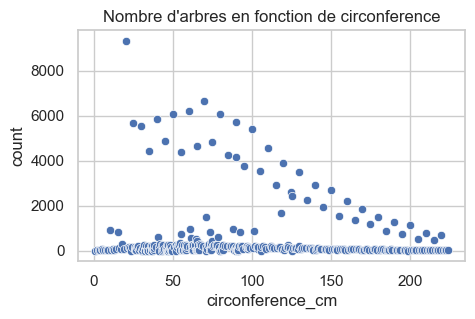

In [20]:
def selectSmallTree(data):    
    Q1_haut = data['hauteur_cm'].quantile(.05)
    Q1_circ = data['circonference_cm'].quantile(.05)
    
    df_sample = data.loc[(data["hauteur_cm"] < Q1_haut) &  (data["circonference_cm"] < Q1_circ) , :]
    
    return (df_sample) 

df_smallTree= selectSmallTree(df)
df_smallTree= df_smallTree.merge(df_2, how='inner', on = 'id')

def verifyYoungTree():
    plt.figure(figsize = (5,3))
    ax = sns.countplot(data = df_smallTree, x = 'stade_developpement')
    ax.set_xticklabels(["Jeune","Jeune-Adulte","Adulte"])
    plt.xlabel('Stade de développement', size=14)
    plt.title(f' Stade de développement sur un échantillon de {df_smallTree.shape[0]} individus inférieur au centile 05:')
    plt.show()
verifyYoungTree()

scatterplot_height(df)
scatterplot_girth(df)

### Mesures de tendance centrale et mesures de dispersion

In [21]:
display(df.describe().round(2))

,id,circonference_cm,geo_point_2d_a,geo_point_2d_b,hauteur_cm
count,186045.00,186045.00,186045.00,186045.00,186045.00
mean,380806.06,85.45,48.85,2.35,985.56
std,535477.13,46.67,0.03,0.05,425.23
min,99874.00,1.00,48.74,2.21,100.00
25%,156332.00,50.00,48.84,2.31,600.00
50%,221630.00,80.00,48.85,2.35,1000.00
75%,273892.00,115.00,48.88,2.39,1200.00
max,2024745.00,224.00,48.91,2.47,2400.00


### Mesures de tendance centrale des genres d'arbres les plus présents
Il sera difficile de faire des mesures de tendance centrale sur les 175 genres d'arbres différents.  
Nous allons nous servir de l'échantillon "common_type" qui regroupe les 9 genres d'arbres les plus présents dans la capitale.

In [22]:
def centralMeasuresCommonType():
    
    for gre in common_type['genre'].unique():
        df_genre = df.loc[df.genre == gre, :]
        print("-"*20)
        print(gre)
        print("Moyenne_hauteur:\n", df_genre['hauteur_cm'].mean(),"\n","Moyenne_circonference:\n", df_genre['circonference_cm'].mean())
        print("Mediane_hauteur:\n", df_genre['hauteur_cm'].median(),"\n", "Mediane_circonference:\n",df_genre['circonference_cm'].median())
        print("Mode_hauteur:\n", df_genre['hauteur_cm'].mode(),"\n", "Mode_circonference:\n", df_genre['circonference_cm'].mode())
    
centralMeasuresCommonType()

--------------------
Aesculus
Moyenne_hauteur:
 1098.5809306820959 
 Moyenne_circonference:
 105.53498350371369
Mediane_hauteur:
 1000.0 
 Mediane_circonference:
 108.0
Mode_hauteur:
 0    1000.0
Name: hauteur_cm, dtype: float64 
 Mode_circonference:
 0    118.299852
Name: circonference_cm, dtype: float64
--------------------
Acer
Moyenne_hauteur:
 1006.9280458087429 
 Moyenne_circonference:
 87.72884088645691
Mediane_hauteur:
 1034.1990310539275 
 Mediane_circonference:
 90.2585048299034
Mode_hauteur:
 0    1034.199031
Name: hauteur_cm, dtype: float64 
 Mode_circonference:
 0    90.258505
Name: circonference_cm, dtype: float64
--------------------
Platanus
Moyenne_hauteur:
 1221.8313821104277 
 Moyenne_circonference:
 101.81299287994122
Mediane_hauteur:
 1200.0 
 Mediane_circonference:
 100.0
Mode_hauteur:
 0    1500.0
Name: hauteur_cm, dtype: float64 
 Mode_circonference:
 0    125.639147
Name: circonference_cm, dtype: float64
--------------------
Sophora
Moyenne_hauteur:
 995.459315

#### Prenons la valeur médiane comme outil de comparaison (moins sensibles aux outliers)
La mediane générale de la hauteur des arbres est de 1000cm pour la hauteur et de 80 cm pour la circonférence.    
On remarque que le Prunus a une mediane qui est bien en dessous de la mediane  générale des arbres. Les arbres qui sont du genre Prunus sont en moyenne plus petit que les autres.  
Au contraire, le Platanus a une mediane qui est bien au dessus de la mediane générale, en se basant sur cette médiane, les arbres du genre Platanus sont donc généralement plus grands que les autres.  

### Mesures de dispersion des genres d'arbres les plus présents (hauteur et circonference)

--------------------
Aesculus - Hauteur
Nombres d'individus: 23504
Q1 quantile de Hauteur :  800
Q2 quantile de Hauteur :  1000.0
Q3 quantile de Hauteur :  1400
L ecart interquartile de hauteur vaut :  600


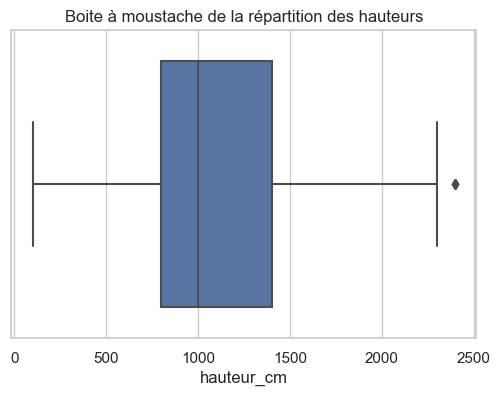

Aesculus - Circonférence
Nombres d'individus: 23504
Q1 quantile de cironference :  65
Q2 quantile de cironference :  108.0
Q3 quantile de cironference :  140
L ecart interquartile de circonference vaut :  75


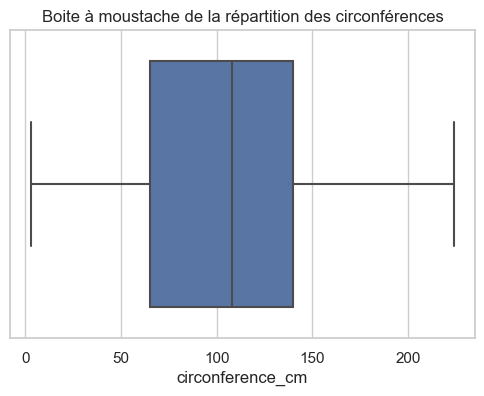

--------------------
Acer - Hauteur
Nombres d'individus: 18121
Q1 quantile de Hauteur :  800
Q2 quantile de Hauteur :  1034.1990310539275
Q3 quantile de Hauteur :  1034
L ecart interquartile de hauteur vaut :  234


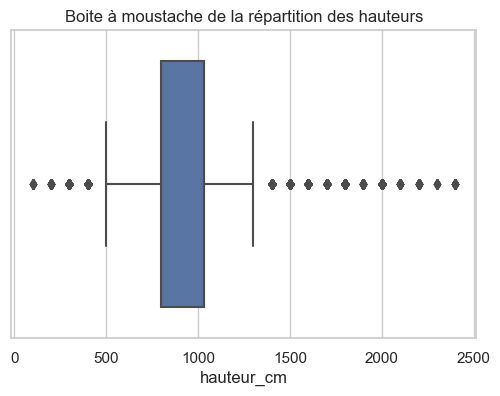

Acer - Circonférence
Nombres d'individus: 18121
Q1 quantile de cironference :  60
Q2 quantile de cironference :  90.2585048299034
Q3 quantile de cironference :  105
L ecart interquartile de circonference vaut :  45


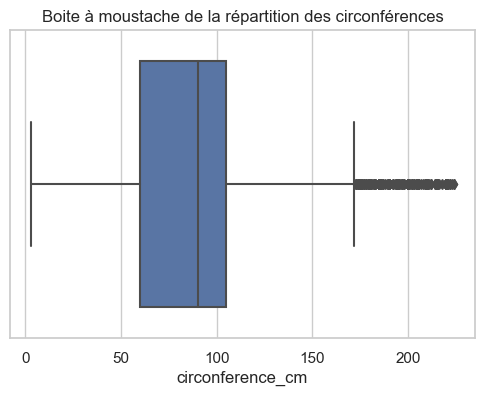

--------------------
Platanus - Hauteur
Nombres d'individus: 38984
Q1 quantile de Hauteur :  900
Q2 quantile de Hauteur :  1200.0
Q3 quantile de Hauteur :  1500
L ecart interquartile de hauteur vaut :  600


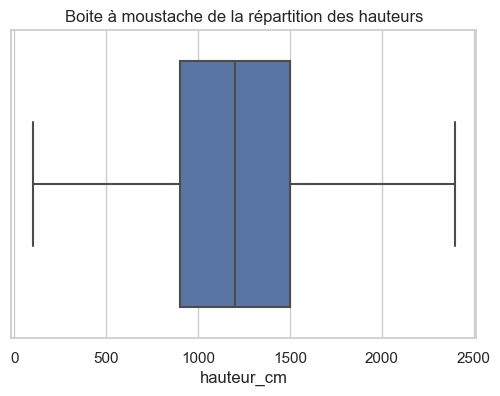

Platanus - Circonférence
Nombres d'individus: 38984
Q1 quantile de cironference :  60
Q2 quantile de cironference :  100.0
Q3 quantile de cironference :  140
L ecart interquartile de circonference vaut :  80


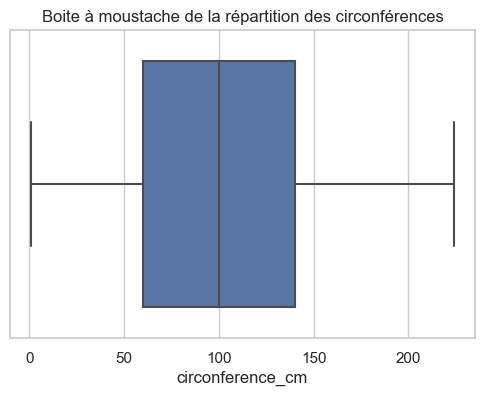

--------------------
Sophora - Hauteur
Nombres d'individus: 11689
Q1 quantile de Hauteur :  600
Q2 quantile de Hauteur :  1000.0
Q3 quantile de Hauteur :  1200
L ecart interquartile de hauteur vaut :  600


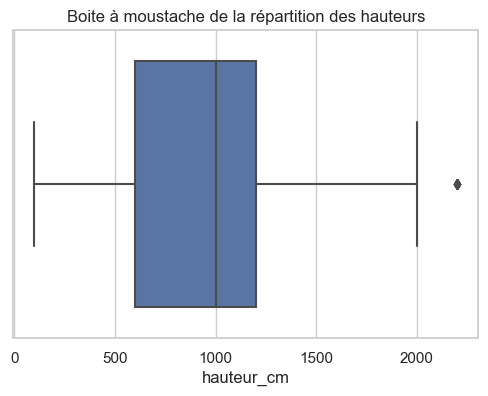

Sophora - Circonférence
Nombres d'individus: 11689
Q1 quantile de cironference :  55
Q2 quantile de cironference :  88.1467991169978
Q3 quantile de cironference :  110
L ecart interquartile de circonference vaut :  55


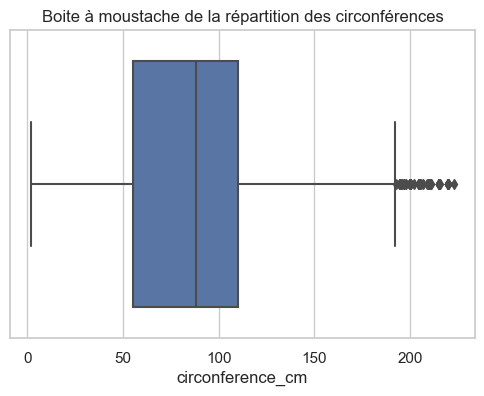

--------------------
Prunus - Hauteur
Nombres d'individus: 6763
Q1 quantile de Hauteur :  500
Q2 quantile de Hauteur :  551.8394648829432
Q3 quantile de Hauteur :  600
L ecart interquartile de hauteur vaut :  100


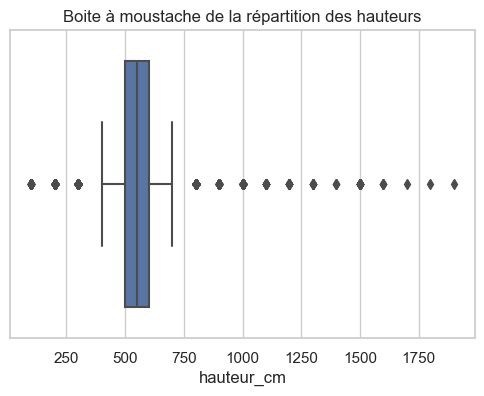

Prunus - Circonférence
Nombres d'individus: 6763
Q1 quantile de cironference :  35
Q2 quantile de cironference :  60.0
Q3 quantile de cironference :  75
L ecart interquartile de circonference vaut :  40


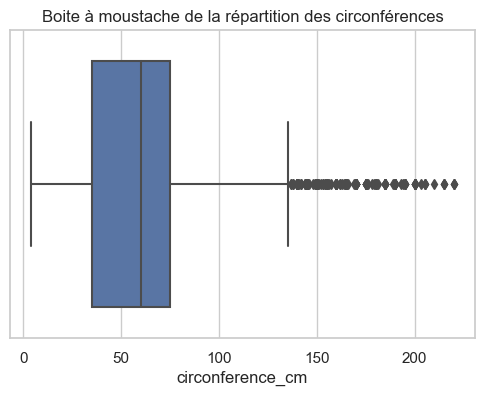

--------------------
Celtis - Hauteur
Nombres d'individus: 4017
Q1 quantile de Hauteur :  500
Q2 quantile de Hauteur :  900.0
Q3 quantile de Hauteur :  1145
L ecart interquartile de hauteur vaut :  645


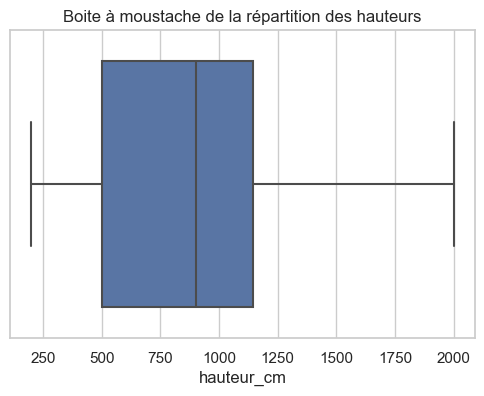

Celtis - Circonférence
Nombres d'individus: 4017
Q1 quantile de cironference :  47
Q2 quantile de cironference :  78.48135039477266
Q3 quantile de cironference :  95
L ecart interquartile de circonference vaut :  48


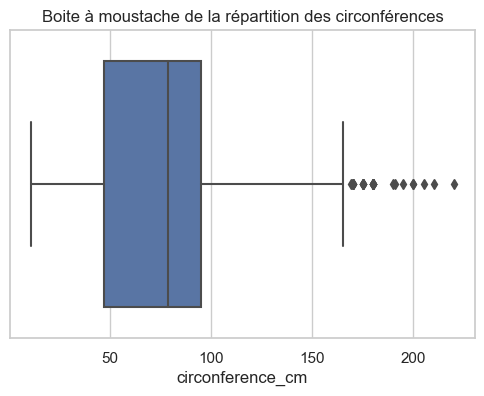

--------------------
Tilia - Hauteur
Nombres d'individus: 17310
Q1 quantile de Hauteur :  800
Q2 quantile de Hauteur :  1000.0
Q3 quantile de Hauteur :  1200
L ecart interquartile de hauteur vaut :  400


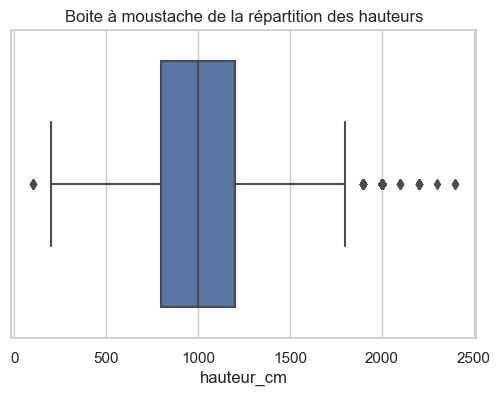

Tilia - Circonférence
Nombres d'individus: 17310
Q1 quantile de cironference :  65
Q2 quantile de cironference :  85.0
Q3 quantile de cironference :  110
L ecart interquartile de circonference vaut :  45


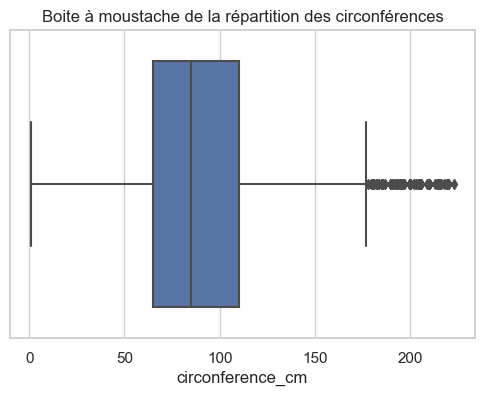

--------------------
Pinus - Hauteur
Nombres d'individus: 4775
Q1 quantile de Hauteur :  900
Q2 quantile de Hauteur :  1024.9179131703759
Q3 quantile de Hauteur :  1025
L ecart interquartile de hauteur vaut :  125


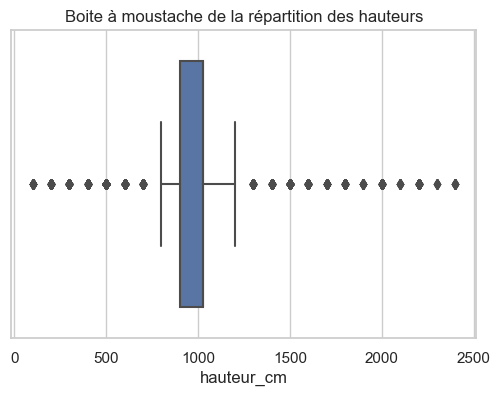

Pinus - Circonférence
Nombres d'individus: 4775
Q1 quantile de cironference :  65
Q2 quantile de cironference :  92.40397022332506
Q3 quantile de cironference :  108
L ecart interquartile de circonference vaut :  43


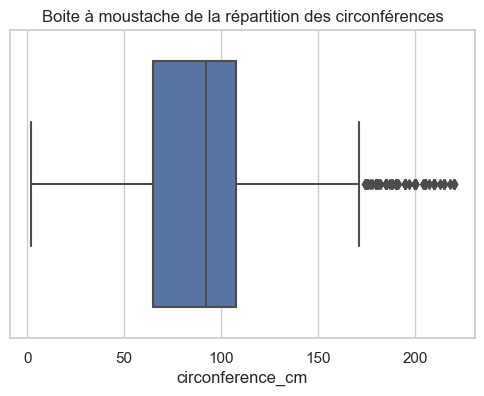

--------------------
Fraxinus - Hauteur
Nombres d'individus: 5933
Q1 quantile de Hauteur :  600
Q2 quantile de Hauteur :  877.3127753303964
Q3 quantile de Hauteur :  1000
L ecart interquartile de hauteur vaut :  400


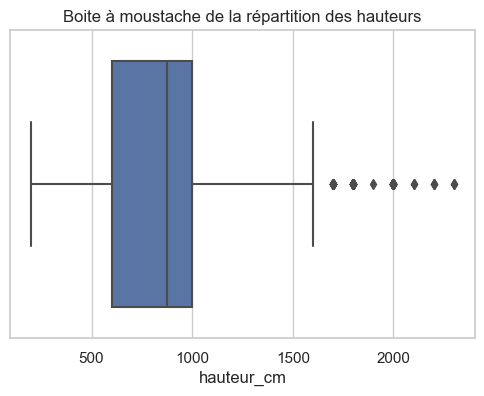

Fraxinus - Circonférence
Nombres d'individus: 5933
Q1 quantile de cironference :  45
Q2 quantile de cironference :  71.16448970555679
Q3 quantile de cironference :  80
L ecart interquartile de circonference vaut :  35


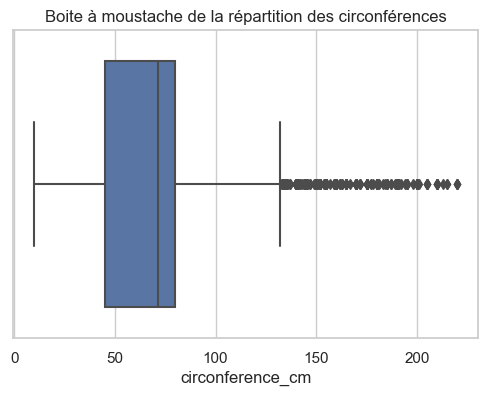

In [23]:
def boxPlotCommonType(hauteur ,circonference, data):
    for gre in common_type['genre'].unique():
        df_genre = data.loc[data.genre == gre, :]
        print("-"*20)
        print(gre, "- Hauteur")
        print("Nombres d'individus:", df_genre.shape[0])
        
        Q1 = round(np.percentile(df_genre[hauteur], 25))
        Q3 = round(np.percentile(df_genre[hauteur], 75))
        print("Q1 quantile de Hauteur : ", Q1)
        print("Q2 quantile de Hauteur : ", np.quantile(df_genre[hauteur], .50))
        print("Q3 quantile de Hauteur : ", Q3)
        print("L ecart interquartile de hauteur vaut : ", Q3 - Q1)
        
        plt.figure(figsize = (6,4))
        sns.boxplot(x= df_genre[hauteur])
        plt.title("Boite à moustache de la répartition des hauteurs")
        plt.show()
        
        print(gre, "- Circonférence")
        print("Nombres d'individus:", df_genre.shape[0])
        Q1 = round(np.percentile(df_genre[circonference], 25))
        Q3 = round(np.percentile(df_genre[circonference], 75))
        print("Q1 quantile de cironference : ", Q1)
        print("Q2 quantile de cironference : ", np.quantile(df_genre[circonference], .50))
        print("Q3 quantile de cironference : ", Q3)
        print("L ecart interquartile de circonference vaut : ", Q3 - Q1)
        
        plt.figure(figsize = (6,4))
        sns.boxplot(x= df_genre[circonference])
        plt.title("Boite à moustache de la répartition des circonférences")
        plt.show()
        
boxPlotCommonType('hauteur_cm', 'circonference_cm', df)        

**Remarque:**  
Le genre d'arbre Prunus possède une faible dispersion pour sa hauteur et sa circonférence avec un écart intercartile de [100; 40] cm.  
Au contraire, les dispersions du Platanus et de l'Aesculus sont très élevées pour ces deux genres d'arbres, ils ont tout deux un écart interquartile de 600cm pour la variable "hauteur_cm".

## Analyse des variables qualitatives

### Analyse de la variable Domanialité

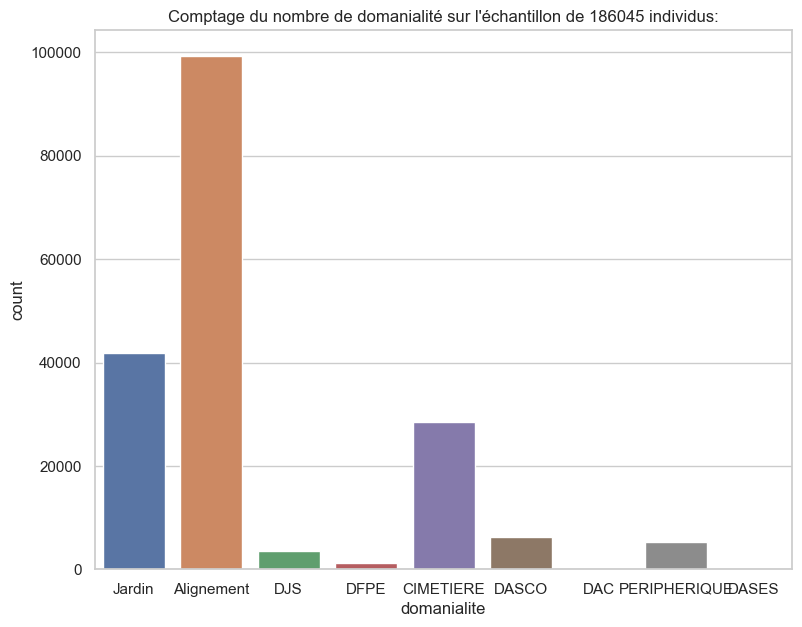

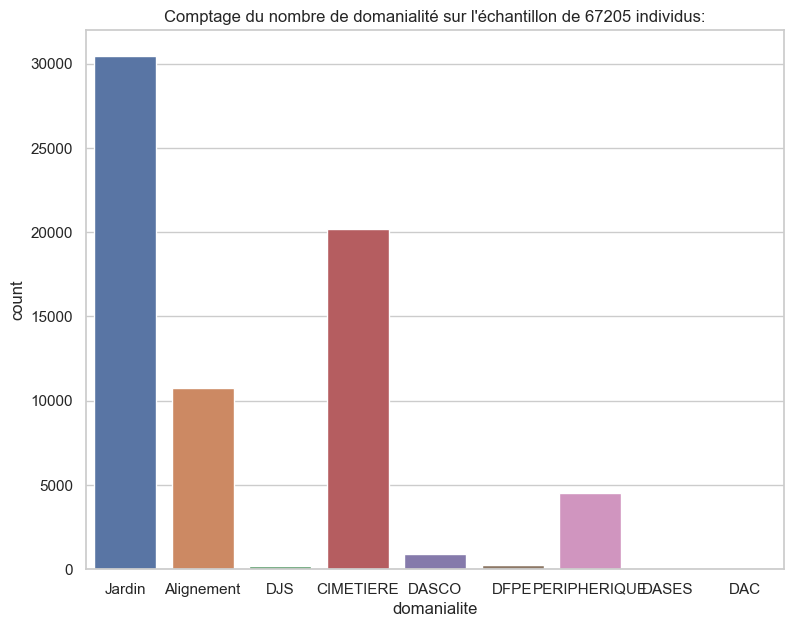

In [24]:
def barPlotDomaniality():
    plt.figure(figsize = (9,7))
    sns.countplot(data = df, x = 'domanialite')
    plt.title(f"Comptage du nombre de domanialité sur l'échantillon de {df.shape[0]} individus:")
    
    plt.figure(figsize = (9,7))
    sns.countplot(data = sample, x = 'domanialite')
    plt.title(f"Comptage du nombre de domanialité sur l'échantillon de {sample.shape[0]} individus:")
barPlotDomaniality()

**Remarque:**  
On observe que la domanialite "Alignement" est la plus présente dans notre jeu de données.  
Cependant, la majorité des arbres ne possèdant pas de stade de développement (échantillon de 67205 individus) se situent dans les Jardins ou dans les Cimetières.

### Analyse de la variable stade_developpement 

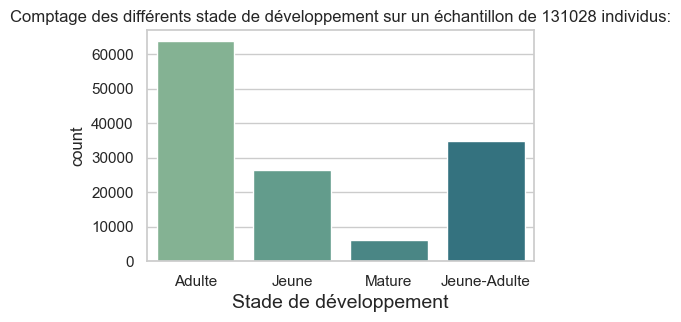

In [25]:
def barPlotStatusDevelopment():
    sns.set_theme(palette = "crest", style = 'whitegrid')
    plt.figure(figsize = (5,3))
    ax = sns.countplot(data = df_2, x = 'stade_developpement')
    ax.set_xticklabels(["Adulte","Jeune","Mature", "Jeune-Adulte"])
    plt.xlabel('Stade de développement', size=14)
    plt.title(f'Comptage des différents stade de développement sur un échantillon de {df_2.shape[0]} individus:')
    plt.show()
    
barPlotStatusDevelopment()

**Remarque:** Le stade de developpement Adulte est le plus présent

### Analyse de la variable arrondissement

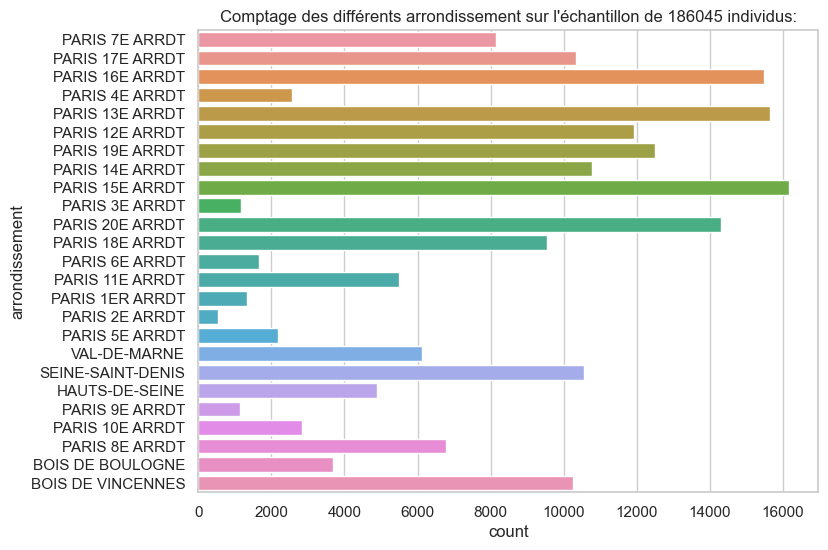

In [26]:
def countPlotDistrict():
    plt.figure(figsize = (8,6))
    sns.countplot(data = df, y = 'arrondissement')
    plt.title(f"Comptage des différents arrondissement sur l'échantillon de {df.shape[0]} individus:")
    plt.show()
    
countPlotDistrict()

**Remarque:**   
Le 15ième arrondissement est l'arrondissement contenant le plus d'individus.  
L'arrondissement qui en contient le moins est le 2ème arrondissement.

### Analyse de la variable espece pour les genres d'arbres les plus présents.

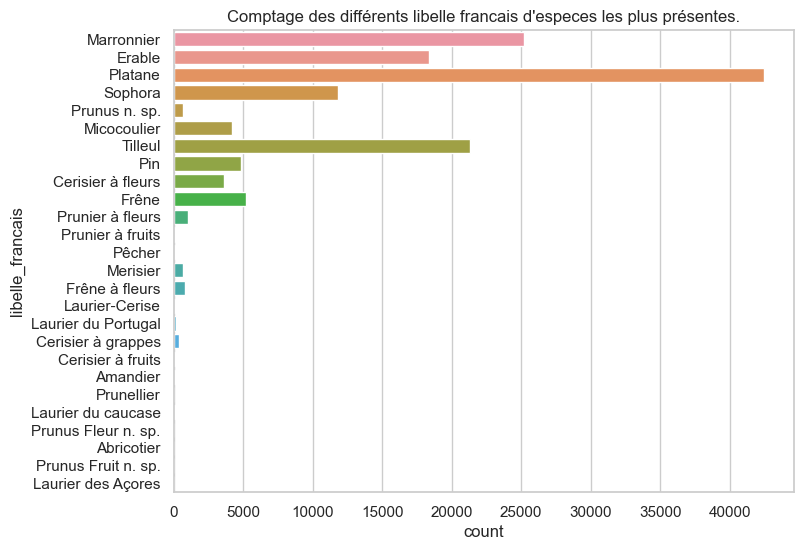

In [27]:
def countPlotSpeciesCommonType():
    plt.figure(figsize = (8,6))
    sns.countplot(data = common_type, y = 'libelle_francais')
    plt.title("Comptage des différents libelle francais d'especes les plus présentes.")
    plt.show()
    
countPlotSpeciesCommonType()

**Remarque:** Le platane est de loin l'espèce la plus présente dans le dataset, suivi par le marronier qui reste cependant bien moins présent. La distribution de la variable "espèces" suis bien la distribution de la variable "genre".

# <div align="center">Synthèse de l'analyse de données</div>

## Représentation visuelle des arbres de la ville de Paris

(2.2102412288, 2.4697594724, 48.7422903048, 48.9114847563)

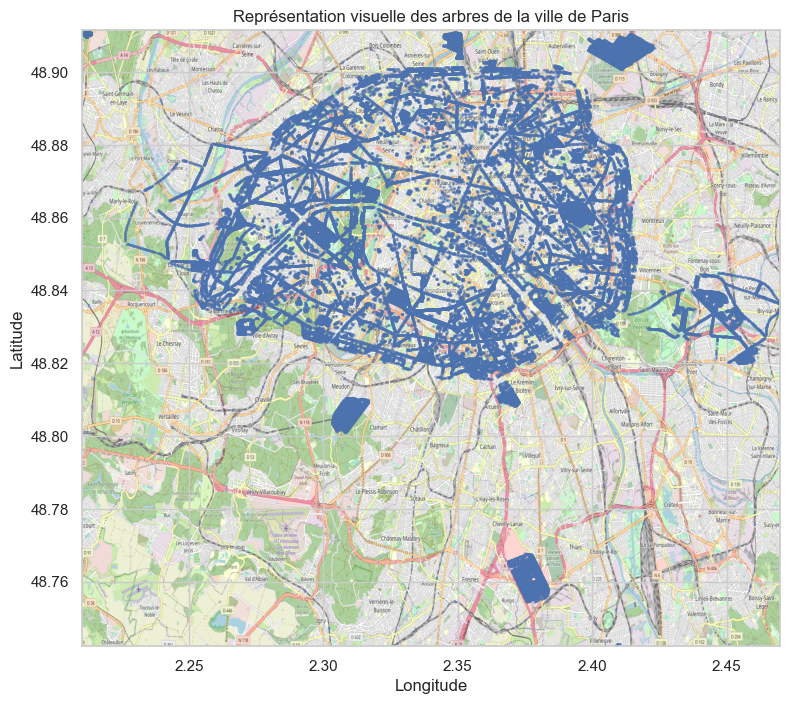

In [28]:
carte = df[["genre", "arrondissement","geo_point_2d_a", "geo_point_2d_b"]]
carte = carte.rename(columns={"geo_point_2d_a": "latitude", "geo_point_2d_b": "longitude"})

BBox = (carte.longitude.min(), carte.longitude.max(),      
         carte.latitude.min(), carte.latitude.max())
display(BBox)

paris = plt.imread('map.png') #image récupéré sur https://www.openstreetmap.org/

fig, ax = plt.subplots(figsize = (9,8))
ax.scatter(carte.longitude, carte.latitude, zorder=1, alpha= 0.2, c='b', s=1)
ax.set_title('Représentation visuelle des arbres de la ville de Paris')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.imshow(paris, extent = BBox, aspect = "auto", alpha = 1)

## Observations:  
Le 15ième arrondissement est le lieu rassemblant le plus d'arbres, il s'avère que c'est également l'arrondissement le plus peuplé avec 848 hectares, il semblerait que c'est un arrondissement prioritaire pour l'entretien des arbres. 
Le 2ième arrondissement est le lieu rassemblant le moins d'arbres, c'est un des arrondissement de Paris également les moins peuplés.

Les arbres qui possèdent un stade de développement sont majoritairement "Adulte". 
La majorité des arbres se situent dans la domanialité "Alignement", ce qui est également observable sur la carte.    
La majorité des arbres sans stade de developpement se situent en "Jardin" ou en "Cimetière". Il serait intéressant de savoir pourquoi la plupart des arbres qui se trouvent en "Jardin" ou en "Cimetière" ne possèdent pas de stade de développement afin de pouvoir optimiser les tournées des arbres de la ville. 

La moyenne de la hauteur des arbres du genre Platanus est de 1221.83 cm, si on la compare à la moyenne générale, on observe que les arbres provenant de ce genre sont en général plus grand que les autres et possèdent une dispersion plus élevée. 
C'est également le genre d'arbre le plus présent dans la ville de Paris.
La moyenne de la hauteur des arbres du genre Prunus est de 543.65 cm, si on la compare à la moyenne générale, on observe que les arbres provenant de ce genre sont en général plus petit que les autres et possèdent une faible dispersion.

On observe enfin sur la carte que la majorité des arbres sont dans Paris intra-Muros, mais qu'il existe toutefois des forêts composés d'arbres de la ville de Paris dans les banlieus plus éloignées, comme celle entre Aubervilliers et Bobigny.